## Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np 
from datetime import timedelta 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

## Import datasets

In [2]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")

vessels_df = pd.read_csv('data/vessels.csv', sep = '|')

ports_df = pd.read_csv('data/ports.csv', sep = '|')
ports_df['latitude_portId'] = ports_df['latitude']
ports_df['longitude_portId'] = ports_df['longitude']
ports_df = ports_df.drop(columns = ['latitude', 'longitude'])

test_df = pd.read_csv('data/ais_test.csv', sep = ',')

schedules_df = pd.read_csv('data/schedules_to_may_2024.csv', sep = '|')


## Preprocessing 

In [3]:
train_df = pd.merge(train_df, ports_df, on = 'portId', how = 'left')

train_df = pd.merge(train_df, vessels_df[['vesselId', 'length', 'GT', 'CEU']], on = 'vesselId')
test_df = pd.merge(test_df, vessels_df[['vesselId', 'length', 'GT', 'CEU']], on = 'vesselId')

train_df = pd.merge(train_df, vessels_df[['vesselId', 'shippingLineId', ]], on = 'vesselId')
test_df = pd.merge(test_df, vessels_df[['vesselId', 'shippingLineId']], on = 'vesselId')


train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])

timestamps = train_df[['time', 'vesselId']]

train_df['second'] = train_df['time'].dt.second
train_df['minute'] = train_df['time'].dt.minute
train_df['hour'] = train_df['time'].dt.hour
train_df['day'] = train_df['time'].dt.day
train_df['day_of_week'] = train_df['time'].dt.dayofweek
train_df['month'] = train_df['time'].dt.month

test_df['second'] = test_df['time'].dt.second
test_df['minute'] = test_df['time'].dt.minute
test_df['hour'] = test_df['time'].dt.hour
test_df['day'] = train_df['time'].dt.day
test_df['day_of_week'] = test_df['time'].dt.dayofweek
test_df['month'] = test_df['time'].dt.month

train_df['time_numeric'] = (train_df['time'] - train_df['time'].min()).dt.total_seconds()
test_df['time_numeric'] = (test_df['time'] - train_df['time'].min()).dt.total_seconds()



In [69]:
train_df = train_df.sort_values(by = 'vesselId', kind = 'stable')
train_df['Delta_time'] = train_df['time'].diff()  
train_df['Delta_latitude'] = train_df['latitude'].diff()  
train_df['Delta_longitude'] = train_df['longitude'].diff() 

test_df = test_df.sort_values(by = 'vesselId', kind = 'stable')
test_df['Delta_time'] = test_df['time'].diff().dt.total_seconds()

display(test_df)

test_df = test_df

,ID,vesselId,time,scaling_factor,length,GT,CEU,shippingLineId,second,minute,hour,day,day_of_week,month,time_numeric,Delta_time
4,4,1,2024-05-08 00:12:27,0.3,182.0,46800,4902,25,27,12,0,1,2,5,11059922.0,NaN
201,201,1,2024-05-08 00:39:27,0.3,182.0,46800,4902,25,27,39,0,1,2,5,11061542.0,1620.0
583,583,1,2024-05-08 01:33:28,0.3,182.0,46800,4902,25,28,33,1,1,2,5,11064783.0,3241.0
701,701,1,2024-05-08 01:51:26,0.3,182.0,46800,4902,25,26,51,1,1,2,5,11065861.0,1078.0
829,829,1,2024-05-08 02:03:29,0.3,182.0,46800,4902,25,29,3,2,1,2,5,11066584.0,723.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51161,51161,687,2024-05-12 22:37:33,0.1,191.0,24133,200,5,33,37,22,5,6,5,11486228.0,1213.0
51302,51302,687,2024-05-12 22:58:05,0.1,191.0,24133,200,5,5,58,22,5,6,5,11487460.0,1232.0
51444,51444,687,2024-05-12 23:18:20,0.1,191.0,24133,200,5,20,18,23,5,6,5,11488675.0,1215.0
51595,51595,687,2024-05-12 23:39:21,0.1,191.0,24133,200,5,21,39,23,5,6,5,11489936.0,1261.0


## Feature engineering 

In [5]:

le_vesselid = LabelEncoder()
le_vesselid.fit(train_df['vesselId'])
train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])
test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])

le_shippingLineId = LabelEncoder()
le_shippingLineId.fit(train_df['shippingLineId'])
train_df['shippingLineId'] = le_shippingLineId.transform(train_df['shippingLineId'])
test_df['shippingLineId'] = le_shippingLineId.transform(test_df['shippingLineId'])


le_portid = LabelEncoder()
le_portid.fit(train_df['portId'])
train_df['portId'] = le_portid.transform(train_df['portId'])

train_df['navstat'] = pd.Categorical(train_df['navstat']).codes

train_df['sog_long'] = 1/60 * 1/3600 * train_df['sog']*np.sin(np.pi/180 * train_df['cog'])*np.cos(train_df['longitude']) #change in longitude per second 
train_df['sog_lat'] = 1/60 * 1/3600 * train_df['sog']*np.cos(np.pi/180 * train_df['cog']) #change in latitude per second 


In [6]:
train_df = train_df.sort_values(by = 'vesselId', kind = 'stable')

train_df['latitude_1'] = train_df['latitude'].shift(1)
train_df['longitude_1'] = train_df['longitude'].shift(1)

train_df['latitude_portId_1'] = train_df['latitude_portId'].shift(1)
train_df['longitude_portId_1'] = train_df['longitude_portId'].shift(1)


train_df['sog_long_1'] = train_df['sog_long'].shift(1)
train_df['sog_lat_1'] = train_df['sog_lat'].shift(1)
 
display(train_df)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,...,Delta_latitude,Delta_longitude,sog_long,sog_lat,latitude_1,longitude_1,latitude_portId_1,longitude_portId_1,sog_long_1,sog_lat_1
131115,2024-01-12 14:07:47,308.1,17.1,-6,316,0,01-08 06:00,7.50361,77.58340,0,...,NaN,NaN,0.000036,0.000049,NaN,NaN,NaN,NaN,NaN,NaN
131279,2024-01-12 14:31:00,307.6,17.3,5,313,0,01-14 23:30,7.57302,77.49505,0,...,0.06941,-0.08835,0.000032,0.000049,7.50361,77.58340,13.263333,80.341111,0.000036,0.000049
131514,2024-01-12 14:57:23,306.8,16.9,5,312,0,01-14 23:30,7.65043,77.39404,0,...,0.07741,-0.10101,0.000026,0.000047,7.57302,77.49505,18.941944,72.885278,0.000032,0.000049
131696,2024-01-12 15:18:48,307.9,16.9,6,313,0,01-14 23:30,7.71275,77.31394,0,...,0.06232,-0.08010,0.000021,0.000048,7.65043,77.39404,18.941944,72.885278,0.000026,0.000047
131885,2024-01-12 15:39:47,307.0,16.3,7,313,0,01-14 23:30,7.77191,77.23585,0,...,0.05916,-0.07809,0.000016,0.000045,7.71275,77.31394,18.941944,72.885278,0.000021,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521244,2024-05-07 22:36:16,324.1,13.5,-2,325,0,05-08 03:00,59.63337,21.43237,687,...,0.05616,-0.10853,0.000031,0.000051,59.57721,21.54090,60.437778,22.216389,0.000055,0.000030
1521409,2024-05-07 22:57:05,324.2,13.3,-3,326,0,05-08 03:00,59.69588,21.34225,687,...,0.06251,-0.09012,0.000029,0.000050,59.63337,21.43237,60.437778,22.216389,0.000031,0.000051
1521625,2024-05-07 23:17:54,356.5,12.2,-1,354,0,05-08 03:00,59.76388,21.35317,687,...,0.06800,0.01092,0.000003,0.000056,59.69588,21.34225,60.437778,22.216389,0.000029,0.000050
1521821,2024-05-07 23:38:13,52.6,17.3,3,50,0,05-08 03:00,59.83316,21.38489,687,...,0.06928,0.03172,-0.000052,0.000049,59.76388,21.35317,60.437778,22.216389,0.000003,0.000056


In [7]:
train_df = train_df.dropna()

In [10]:
features = ['Delta_time', 'second', 'minute', 'hour', 'day', 'day_of_week',
             'vesselId', 'shippingLineId', 'latitude_1', 'longitude_1', 'sog_lat_1', 
             'sog_long_1', 'latitude_portId_1', 'longitude_portId_1', 'length', 'GT']
targets = ['latitude', 'longitude', 'sog_lat', 'sog_long', 'latitude_portId', 'longitude_portId']
X = train_df[features]
y = train_df[targets]

params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'eta':  0.01,
}

dtrain = xgb.DMatrix(X, label = y)
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_boost_round= 500, evals = evals, verbose_eval= 10)
dtrain = xgb.DMatrix(train_df[features])

[0]	train-rmse:44.15388
[10]	train-rmse:40.00952
[20]	train-rmse:36.26314
[30]	train-rmse:32.87786
[40]	train-rmse:29.81817
[50]	train-rmse:27.05413
[60]	train-rmse:24.55715
[70]	train-rmse:22.30276
[80]	train-rmse:20.26838
[90]	train-rmse:18.43294
[100]	train-rmse:16.77737
[110]	train-rmse:15.28538
[120]	train-rmse:13.94209
[130]	train-rmse:12.73334
[140]	train-rmse:11.64601
[150]	train-rmse:10.66897
[160]	train-rmse:9.79173
[170]	train-rmse:9.00617
[180]	train-rmse:8.30423
[190]	train-rmse:7.67817
[200]	train-rmse:7.12073
[210]	train-rmse:6.62669
[220]	train-rmse:6.18912
[230]	train-rmse:5.80239
[240]	train-rmse:5.46226
[250]	train-rmse:5.16340
[260]	train-rmse:4.90235
[270]	train-rmse:4.67523
[280]	train-rmse:4.47865
[290]	train-rmse:4.30816
[300]	train-rmse:4.16169
[310]	train-rmse:4.03575
[320]	train-rmse:3.92658
[330]	train-rmse:3.83248
[340]	train-rmse:3.75190
[350]	train-rmse:3.68360
[360]	train-rmse:3.62276
[370]	train-rmse:3.56879
[380]	train-rmse:3.52202
[390]	train-rmse:3.4

In [11]:
lat_pred = []
long_pred = []
lat_portId_pred = []
long_portId_pred = []
sog_lat_pred = []
sog_long_pred = []
predictions = []
last_position = {}


for index, row in test_df.iterrows():
    vessel = row['vesselId']
    if(vessel in last_position):
        lat,long, sog_lat, sog_long, lat_portId, long_portId = last_position[vessel]
    else:
        lat = np.array(train_df[train_df['vesselId']  == vessel]['latitude'])[-1] 
        long = np.array(train_df[train_df['vesselId']  == vessel]['longitude'])[-1]
        sog_lat = np.array(train_df[train_df['vesselId']  == vessel]['sog_lat'])[-1]
        sog_long = np.array(train_df[train_df['vesselId']  == vessel]['sog_long'])[-1]
        lat_portId = np.array(train_df[train_df['vesselId']  == vessel]['latitude_portId'])[-1]
        long_portId = np.array(train_df[train_df['vesselId']  == vessel]['longitude_portId'])[-1]    
            
    print(index, end = '\r')

    X_data = {'Delta_time': row['Delta_time'], 'second':row['second'], 'minute':row['minute'] , 'hour':row['hour'],
              'day':row['day'], 'day_of_week':row['day_of_week'], 'vesselId': row['vesselId'], 'shippingLineId':row['shippingLineId'], 
              'latitude_1':lat, 'longitude_1':long, 'sog_lat_1':sog_lat, 'sog_long_1':sog_long, 'latitude_portId_1':lat_portId,  
              'longitude_portId_1':long_portId, 'length':row['length'], 'GT':row['GT']}
    X = pd.DataFrame(data = X_data, index = [0])
    dtest = xgb.DMatrix(X)
    prediction = model.predict(dtest)
    last_position[vessel] = prediction[0]   
    lat_pred.append(prediction[0][0])
    long_pred.append(prediction[0][1])
    sog_lat_pred.append(prediction[0][2])
    sog_long_pred.append(prediction[0][3])
    lat_portId_pred.append(prediction[0][4])
    long_portId_pred.append(prediction[0][5])
    
    predictions.append(prediction[0])

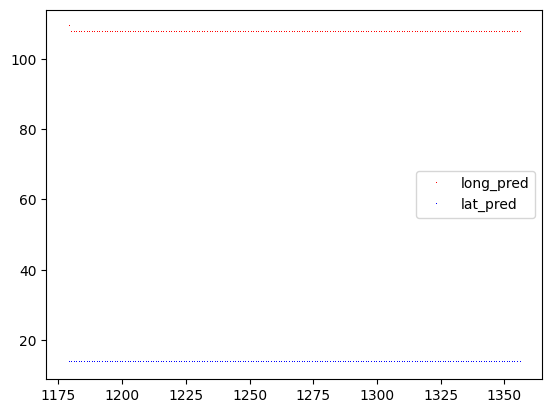

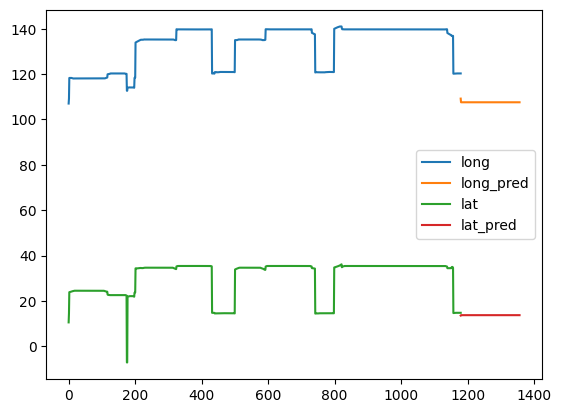

In [16]:
predictions = np.array(predictions)

latitudes_predicted = predictions[:,0] 
longitudes_predicted = predictions[:,1] 

test_df['longitude_predicted'] = long_pred
test_df['latitude_predicted'] = lat_pred

vesselId = 1
vessel = test_df['vesselId'].unique()[vesselId]

vessel_data_train = train_df[train_df['vesselId'] == vessel]
vessel_data_test = test_df[test_df['vesselId'] == vessel]

N = len(vessel_data_train['longitude'])
M = len(vessel_data_test['longitude_predicted'])

index_train = np.linspace(0, N,N)
index_test = np.linspace(N, N+M,M)

plt.plot(index_test, vessel_data_test['longitude_predicted'], 'r,', label = 'long_pred')
plt.plot(index_test, vessel_data_test['latitude_predicted'], 'b,', label = 'lat_pred')
plt.legend()
plt.figure()
plt.plot(index_train, vessel_data_train['longitude'], label = 'long')
plt.plot(index_test, vessel_data_test['longitude_predicted'], label = 'long_pred')
plt.plot(index_train, vessel_data_train['latitude'],label = 'lat')
plt.plot(index_test, vessel_data_test['latitude_predicted'], label = 'lat_pred')
plt.legend()

In [13]:
submission = pd.DataFrame(test_df[['ID','longitude_predicted', 'latitude_predicted']])
submission.to_csv('submission_21_10.csv', index = False)

In [14]:
from geopy.distance import geodesic
submission_best = pd.read_csv('submission_16_10.csv')
submission_today = pd.read_csv('submission_21_10.csv')
latitude_best = submission_best['latitude_predicted']
longitude_best = submission_best['longitude_predicted']
latitudes_today = submission_today['latitude_predicted']
longitudes_today = submission_today['longitude_predicted']
distances = []
weights = test_df['scaling_factor']
for i in range(len(longitude_best)):
    distance = geodesic((latitude_best[i], longitude_best[i]), 
                        (latitudes_today[i], longitudes_today[i])).meters
    distances.append(distance*weights[i])

print((np.mean(distances)) /1000)
    

142.63154498992589


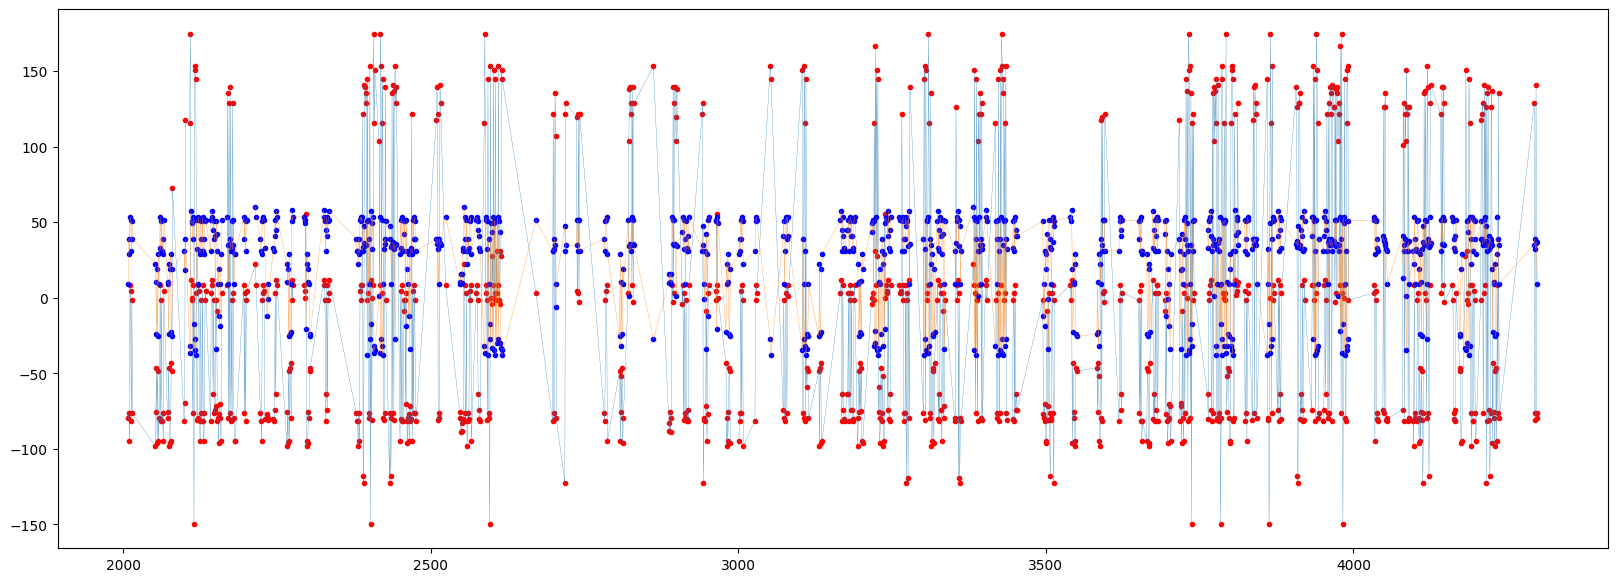

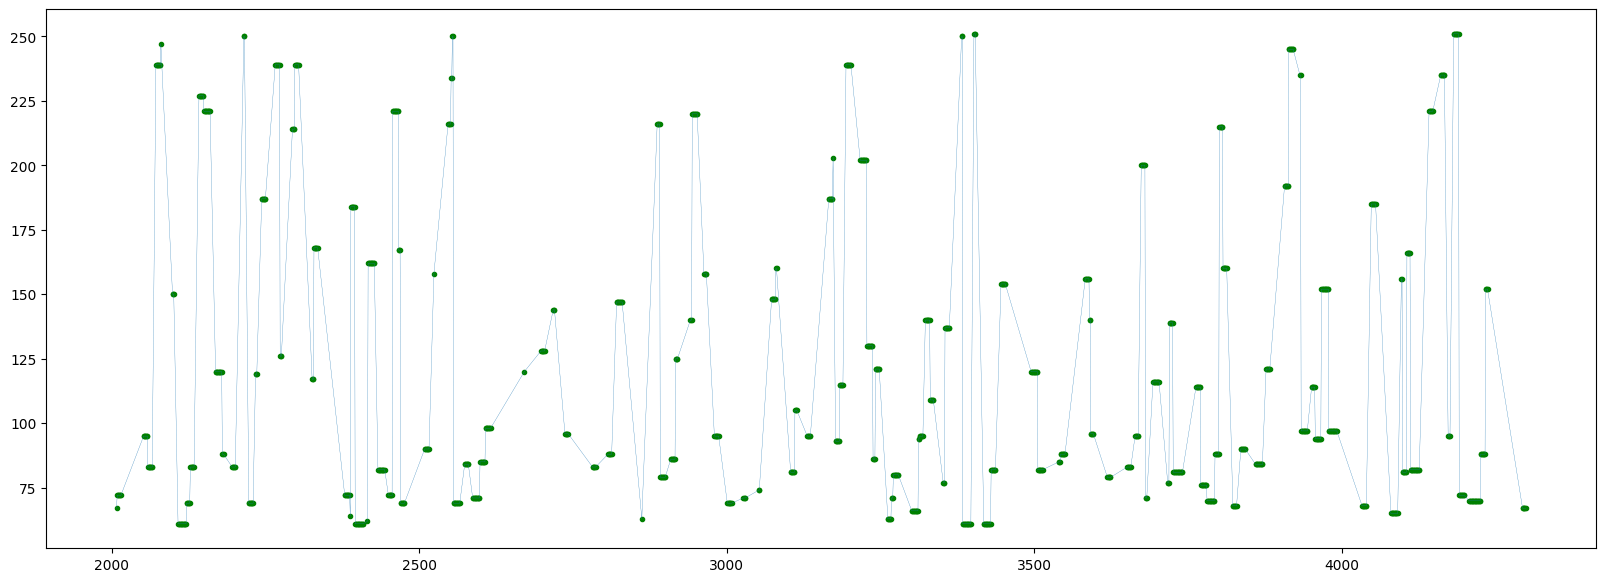

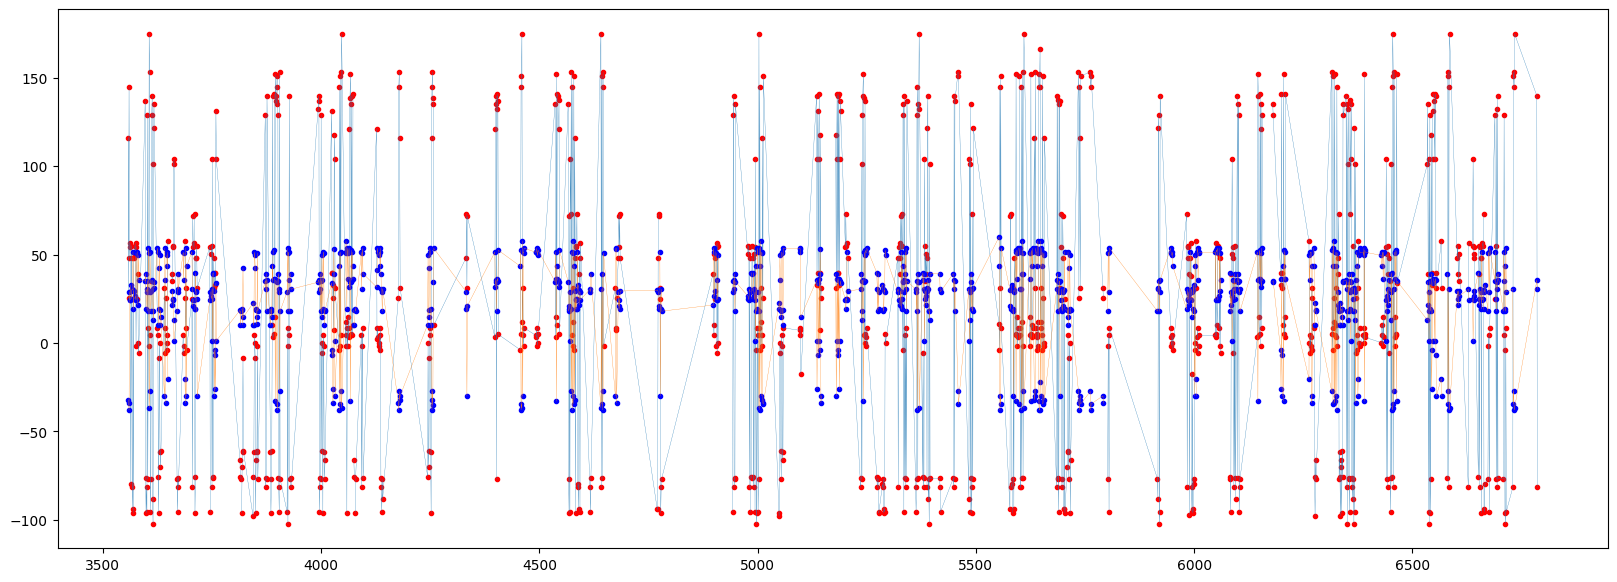

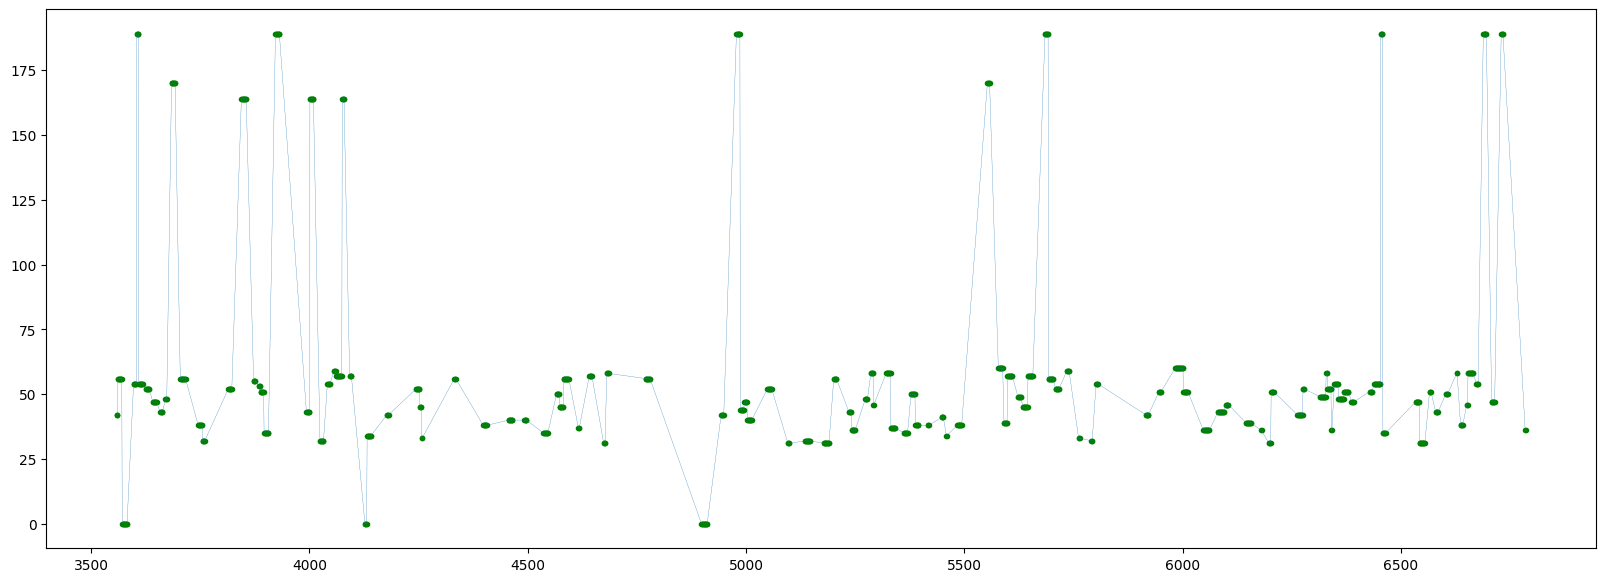

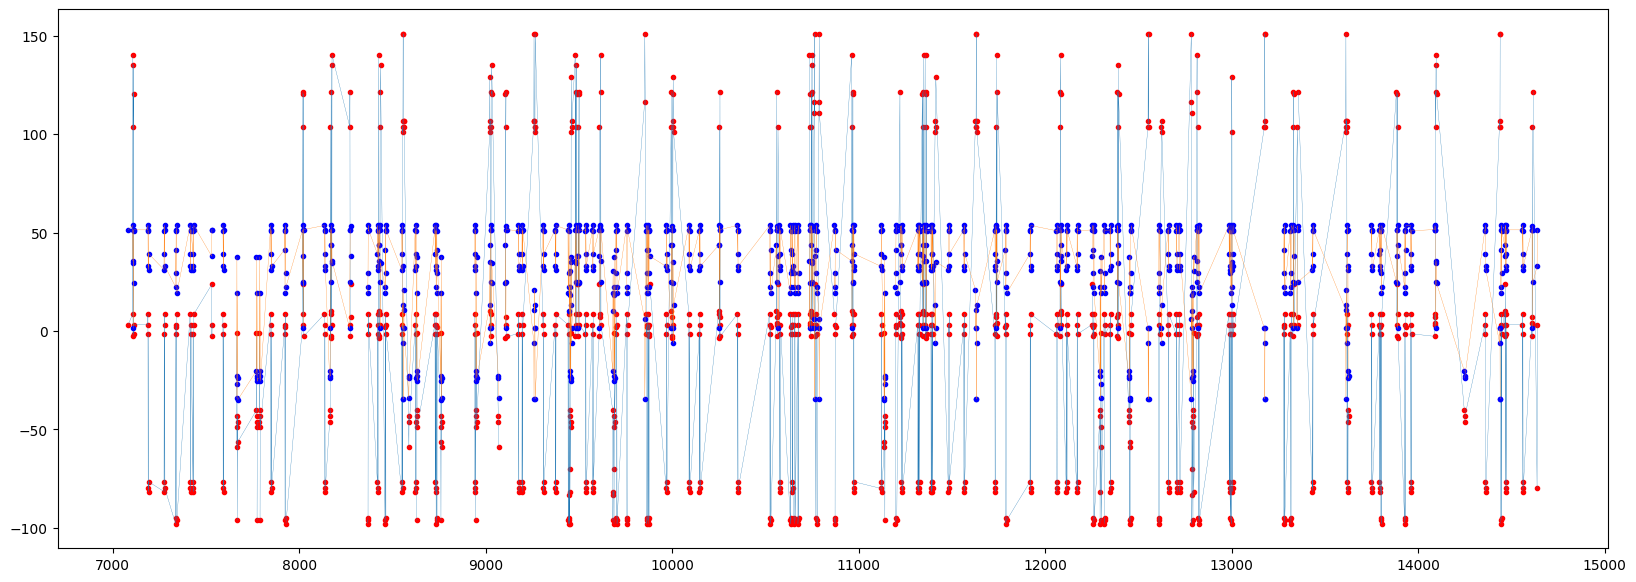

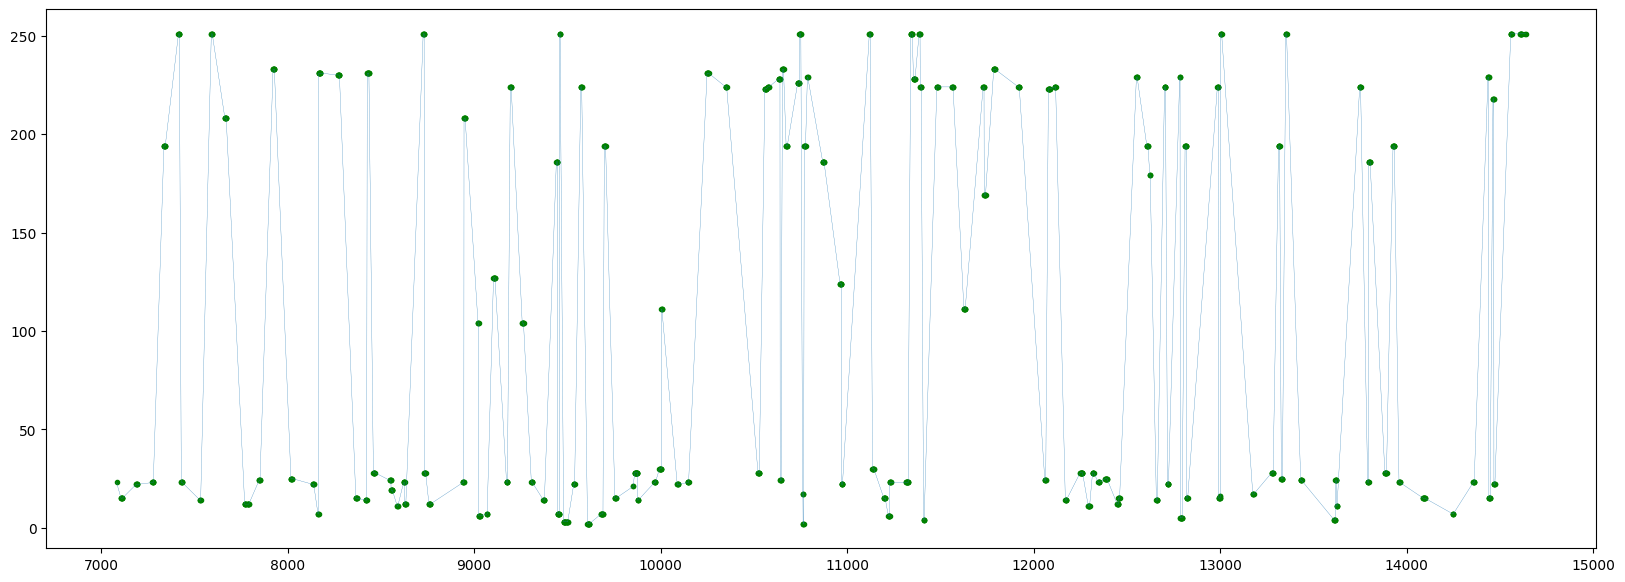

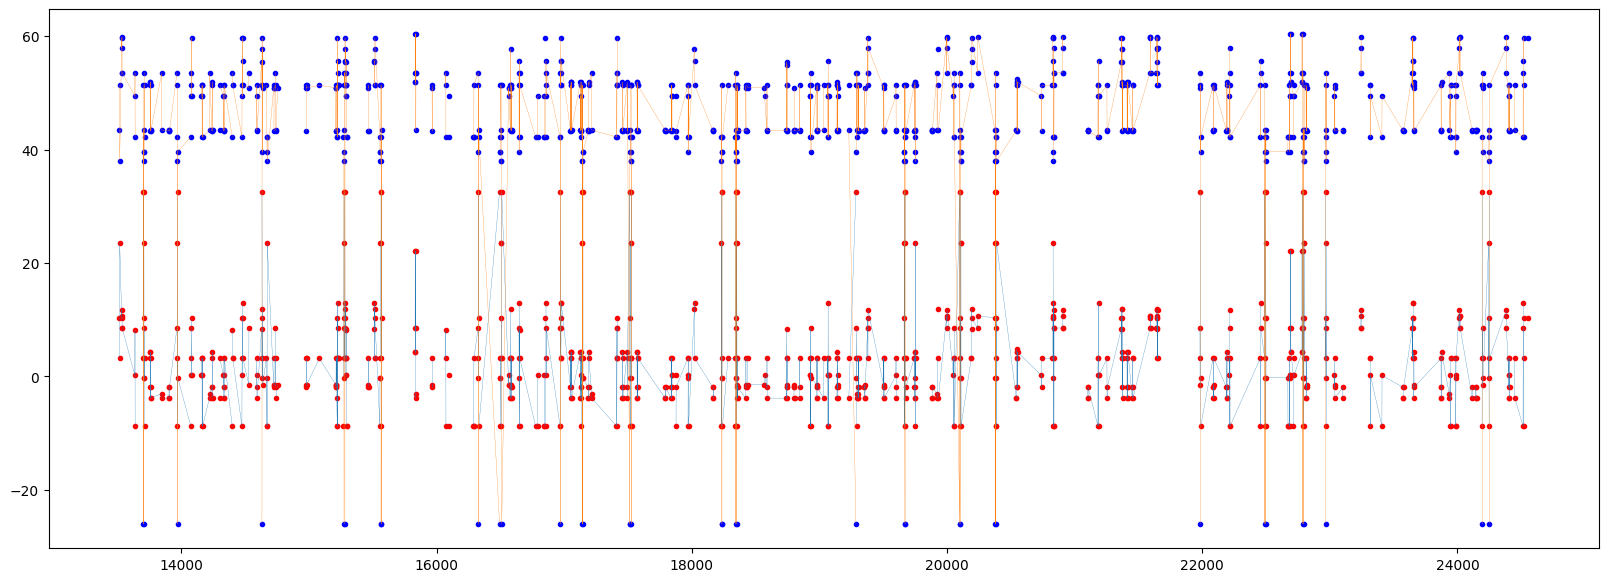

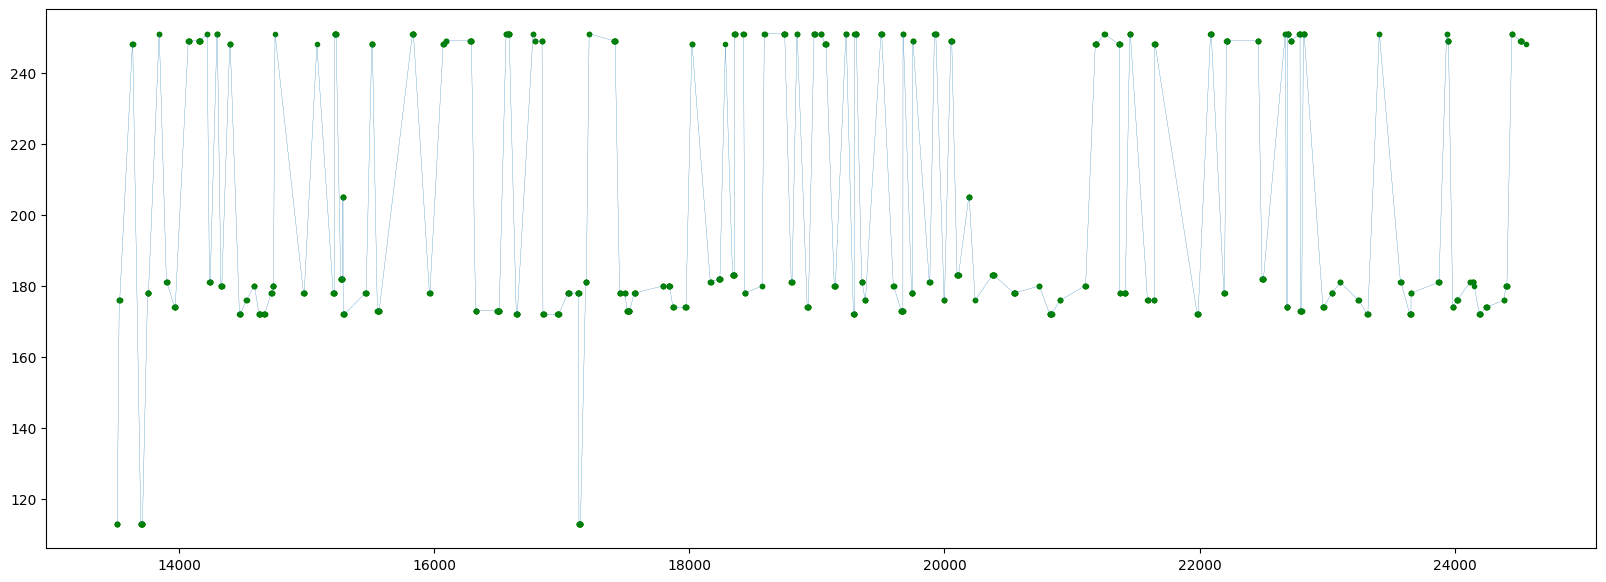

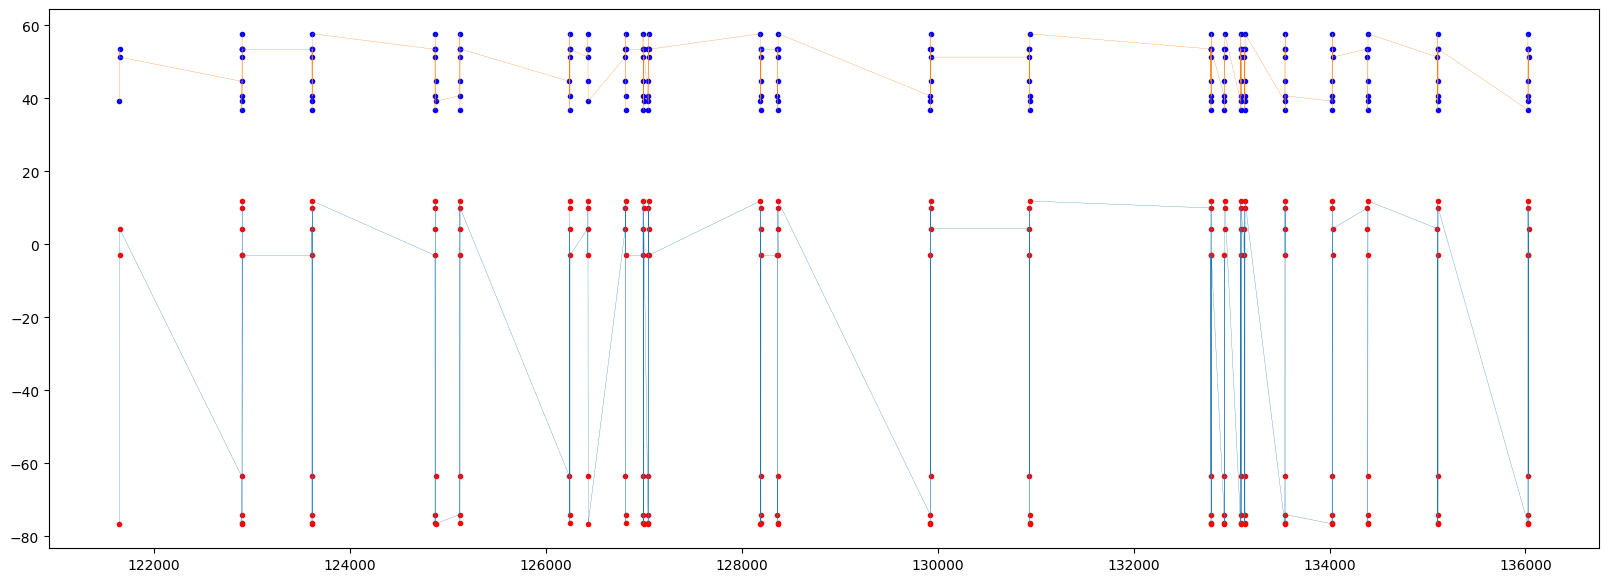

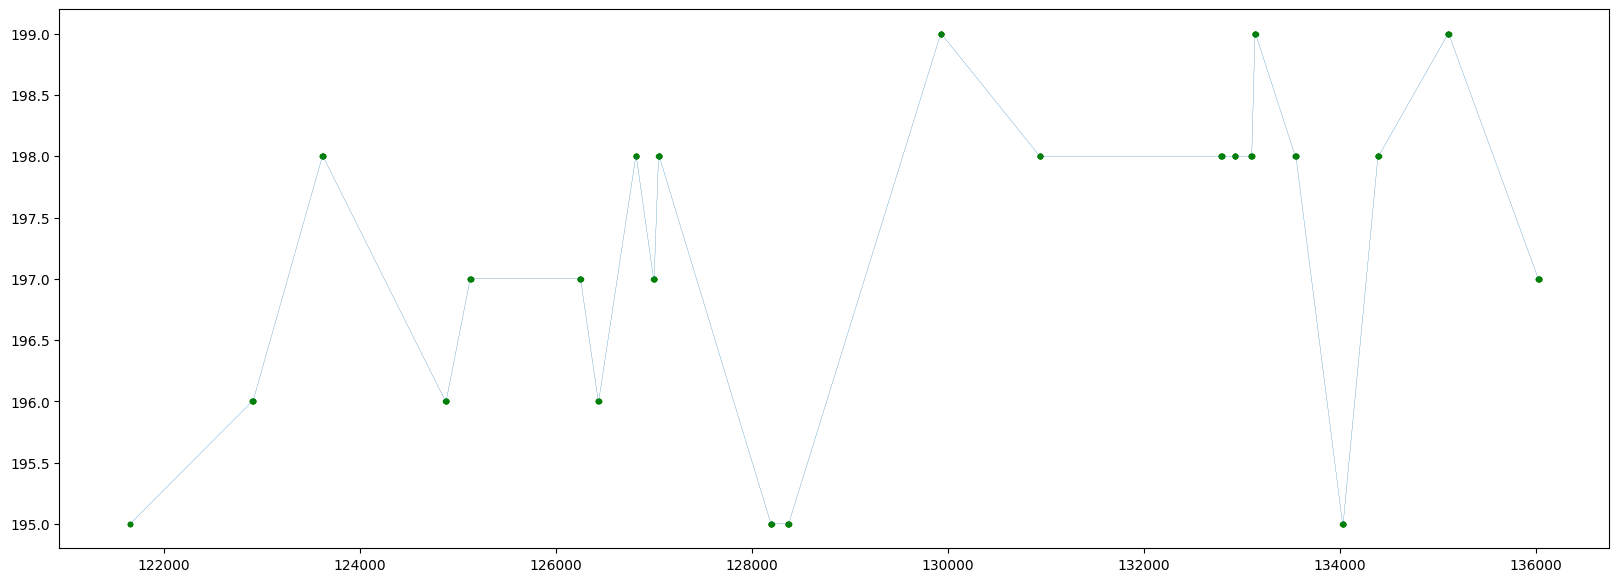

In [57]:
shippingLines = schedules_df['shippingLineId'].unique()
le_vesselid = LabelEncoder().fit(schedules_df['vesselId'].unique())
schedules_df['vesselId'] = le_vesselid.transform(schedules_df['vesselId'])

plt.rcParams['lines.linewidth'] = 0.2
for shippingLine in shippingLines:
    shippingLine_data = schedules_df[schedules_df['shippingLineId'] == shippingLine]

    start = 1000
    stop = 2000

    plt.figure(figsize = (20,7))
    plt.plot(shippingLine_data['portLongitude'][start:stop], 'r.')
    plt.plot(shippingLine_data['portLongitude'][start:stop])
    plt.plot(shippingLine_data['portLatitude'][start:stop], 'b.')
    plt.plot(shippingLine_data['portLatitude'][start:stop])

    plt.figure(figsize = (20,7))
    plt.plot(shippingLine_data['vesselId'][start:stop], 'g.')
    plt.plot(shippingLine_data['vesselId'][start:stop])

In [63]:
schedules_df['vesselId'] = le_vesselid.inverse_transform(schedules_df['vesselId'])
display(schedules_df.isna().sum())
display(schedules_df.iloc[124])

vesselId               0
shippingLineId         0
shippingLineName       0
arrivalDate         5515
sailingDate         1881
portName            4402
portId              4402
portLatitude        4402
portLongitude       4402
dtype: int64

vesselId                                   152
shippingLineId        61a8e672f9cba188601e84ac
shippingLineName    Wallenius Wilhelmsen Ocean
arrivalDate          2023-08-22 00:00:00+00:00
sailingDate          2023-08-26 00:00:00+00:00
portName              Port of Bruges-Zeebrugge
portId                61d36f9a0a1807568ff9a156
portLatitude                         51.336389
portLongitude                         3.207222
Name: 124, dtype: object